In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

In [2]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

In [5]:
df= pd.read_csv('data/train_clean.csv')
df.dropna(inplace=True)
X = df.drop(['Y'], axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0
)

In [6]:
def preprocessing(sub, X_train_sub, X_test_sub):
    numeric_features = copy.copy(sub)
    categorical_features = list()
    if "X11" in sub:
        numeric_features.remove("X11")
        categorical_features.append("X11")
    if "X12" in sub:
        numeric_features.remove("X12")
        categorical_features.append("X12")

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')), # mean, median, most_frequent
        ('scaler', StandardScaler())], verbose=True)

    if len(categorical_features) > 1:
        X_train_sub = X_train_sub.astype({'X11':'category', 'X12':'category'})
        X_test_sub = X_test_sub.astype({'X11':'category', 'X12':'category'})
    elif len(categorical_features) == 1:
        if categorical_features[0] == "X11":
            X_train_sub = X_train_sub.astype({'X11':'category'})
            X_test_sub = X_test_sub.astype({'X11':'category'})
        else:
            X_train_sub = X_train_sub.astype({'X12':'category'})
            X_test_sub = X_test_sub.astype({'X12':'category'})

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # obligatoire
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))], verbose=True) #Same as pd.get_dummies 

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return preprocessor, X_train_sub, X_test_sub

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.0s


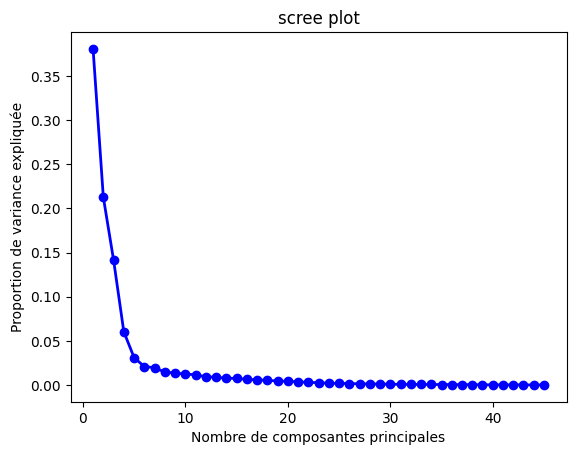

In [8]:
sub = ["X1", "X6", "X10", "X11", "X12"]
X_train_sub = X_train[sub]
X_test_sub = X_test[sub]


preprocessor, X_train_sub, X_test_sub = preprocessing(sub, X_train_sub, X_test_sub)
pca = PCA()
Pipe2 = Pipeline(steps = [('preprocessor', preprocessor),('to_dense', DenseTransformer()), ('pca', pca)])
Pipe2.fit(X_train_sub)

variance_ratio = pca.explained_variance_ratio_

#tracons le scree plot
plt.plot(np.arange(1, len(variance_ratio)+1), variance_ratio, 'bo-', linewidth=2)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de variance expliquée')
plt.title('scree plot')
plt.show()